# Undersatanding PubMed GitHub repositories with the Software Gardening Almanack

The content below seeks to better understand a dataset of ~10,000 PubMed article GitHub repositories using the Software Gardening Almanack.

PubMed GitHub repositories are extracted using the PubMed API to query for GitHub links within article abstracts.
GitHub data about these repositories is gathered using the GitHub API.
The code to perform data extractions may be found under the directory: [gather-pubmed-repos](https://github.com/software-gardening/almanack/tree/main/src/book/seed-bank/pubmed-github-repositories/gather-pubmed-repos/) .

These repositories are then processed using the Software Gardening Almanack to contextualize how they compare to one another.

## Data Extraction

The following section extracts data which includes software entropy and GitHub-derived data.
We merge the data to form a table which includes PubMed, GitHub, and Almanack software entropy information on the repositories.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

from almanack import process_repositories_batch

# set plotly default theme
pio.templates.default = "plotly_white"

# set almanack data directory
ALMANACK_DATA_DIR = "repository_analysis_results"

In [2]:
# if we don't already have a data dir, batch process almanack data
if not pathlib.Path(ALMANACK_DATA_DIR).is_dir():
    process_repositories_batch(
        # read pre-collected pubmeb github repos
        repo_urls=pd.read_parquet(
            path="gather-pubmed-repos/pubmed_github_links_with_github_data.parquet",
            columns=["github_link"],
        )
        .dropna()
        .github_link.tolist()[1:20],
        output_path=ALMANACK_DATA_DIR,
        split_batches=True,
        batch_size=500,
        max_workers=8,
        collect_dataframe=False,
        show_repo_progress=False,
        show_batch_progress=True,
    )

# read the dataset as a concenated dataframe from parquet chunks
df = pd.concat(
    [
        pd.read_parquet(pq_file)
        for pq_file in pathlib.Path(ALMANACK_DATA_DIR).glob("*.parquet")
    ],
    ignore_index=True,
    sort=False,
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9631 entries, 0 to 9630
Data columns (total 62 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Repository URL                                            9631 non-null   object 
 1   repo-path                                                 9631 non-null   object 
 2   repo-commits                                              9587 non-null   float64
 3   repo-file-count                                           9587 non-null   float64
 4   repo-commit-time-range                                    9631 non-null   object 
 5   repo-days-of-development                                  9587 non-null   float64
 6   repo-commits-per-day                                      9587 non-null   float64
 7   almanack-table-datetime                                   9631 non-null   object 
 8   almanack-version  

/var/folders/zw/l3g4vq6508g98qkt05z6hb_m0000gp/T/ipykernel_63494/2236761407.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


## How many repositories are dormant?

Software must evolve continuously to remain stable, useful, and aligned with current needs.
The following section explores how repository dormancy appears within the dataset based on the date of most recent commit.
Sustained, incremental updates help prevent this stagnation and ensure that a project continues to serve its users effectively.

In [3]:
# cleanup: drop columns or rows whose values are all empty
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="all")

In [4]:
# gather repo commit start and end dates
df[["repo-commit-start-date", "repo-commit-end-date"]] = df[
    "repo-commit-time-range"
].str.extract(r"\('([^']+)', '([^']+)'\)")
# turn these into datetimes for datetime calcs
df[["repo-commit-start-date", "repo-commit-end-date"]] = df[
    ["repo-commit-start-date", "repo-commit-end-date"]
].apply(pd.to_datetime)
# set a cuttoff of 1 year for dormancy
cutoff = pd.Timestamp.now() - pd.DateOffset(years=1)
df["dormant"] = df["repo-commit-end-date"] <= cutoff
# show how many dormant repos there are in this dataset
df["dormant"].value_counts()

dormant
True     8050
False    1581
Name: count, dtype: int64

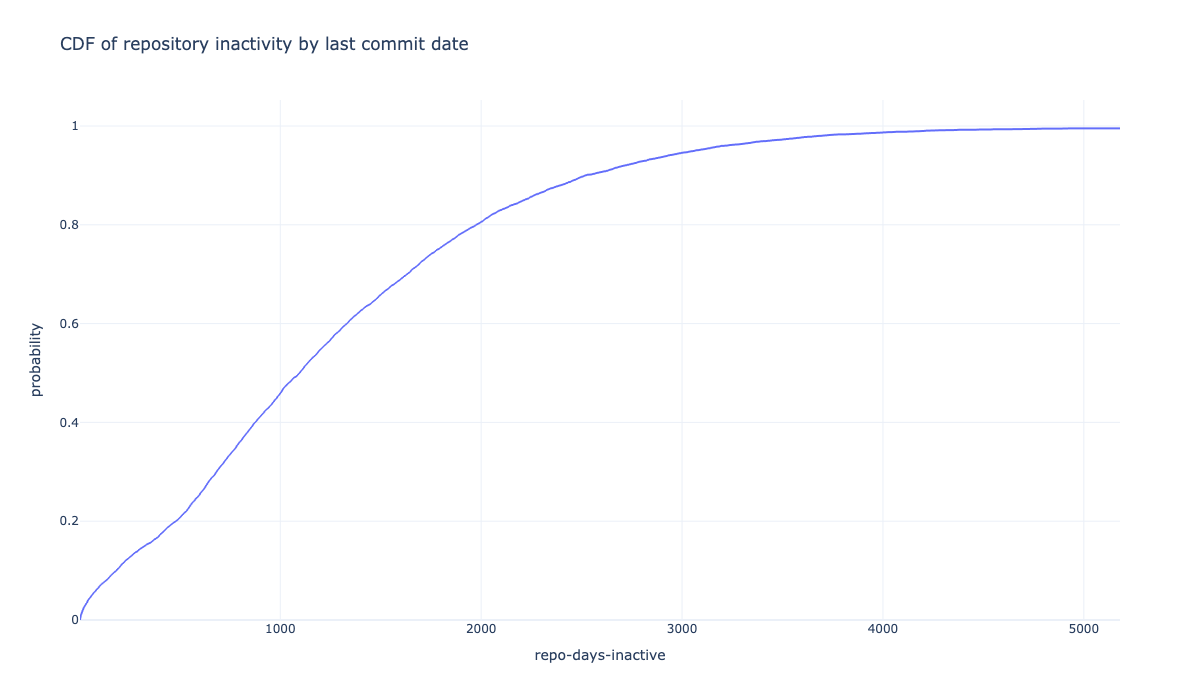

In [5]:
df["repo-days-of-existence"] = (
    pd.Timestamp.now() - df["repo-commit-start-date"]
).dt.days
df["repo-days-inactive"] = (pd.Timestamp.now() - df["repo-commit-end-date"]).dt.days
fig = px.ecdf(
    df,
    x="repo-days-inactive",
    title="CDF of repository inactivity by last commit date",
    width=1200,
    height=700,
)
fig.write_image(
    image_file := "images/cdf_repository_inactivity_by_last_commit_date.png"
)
display(Image(filename=image_file))

## What languages are used within PubMed article repositories?

The following section observes the top 10 languages which are used in repositories from the dataset.
Primary language is determined as the language which has the most lines of code within a repository.

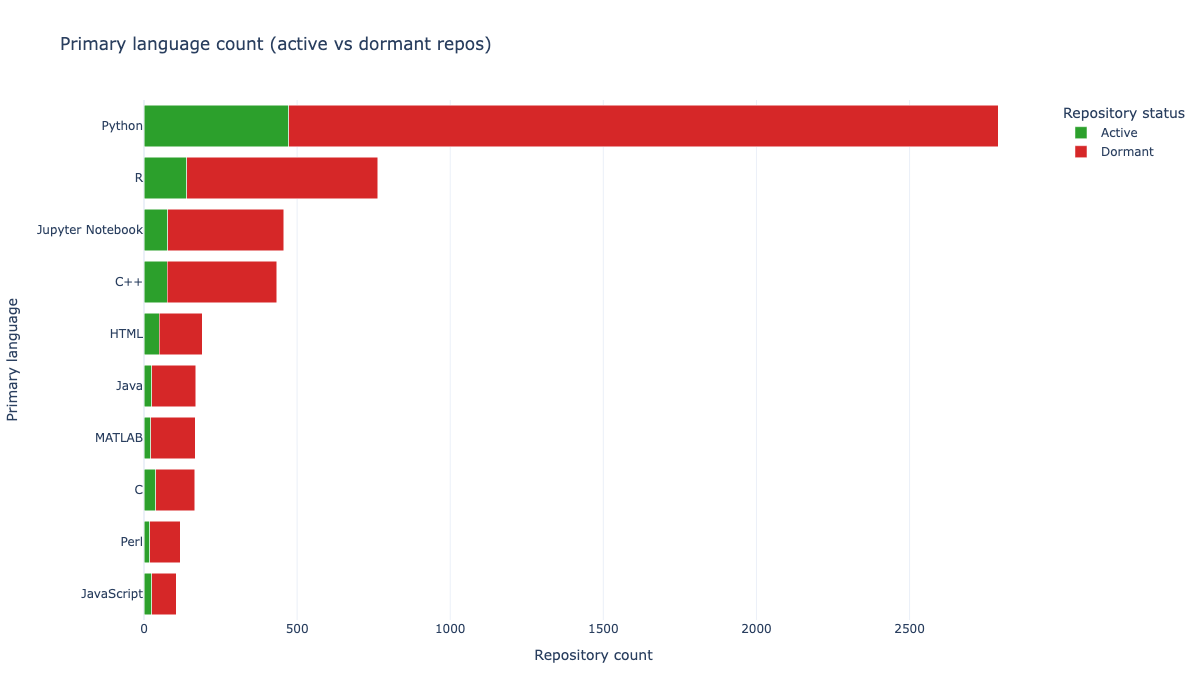

In [6]:
# Count dormant & active repos per language
lang_status = (
    df.groupby(["repo-primary-language", "dormant"]).size().reset_index(name="Count")
)

# Map boolean to readable labels
lang_status["Status"] = lang_status["dormant"].map(
    {
        True: "Dormant",
        False: "Active",
    }
)

# Total repos per language
total_counts = lang_status.groupby("repo-primary-language")["Count"].sum()

# Top 10 languages by total repo count (sorted)
top_langs = total_counts.sort_values().tail(10)

# Filter to top languages
plot_data = lang_status[
    lang_status["repo-primary-language"].isin(top_langs.index)
].copy()

# Ensure y-axis follows the sorted order by total count
lang_order = top_langs.index.tolist()
plot_data["repo-primary-language"] = pd.Categorical(
    plot_data["repo-primary-language"],
    categories=lang_order,
    ordered=True,
)

# Stacked horizontal bar chart: Active (green) + Dormant (red)
fig = px.bar(
    plot_data,
    y="repo-primary-language",
    x="Count",
    color="Status",
    orientation="h",
    color_discrete_map={
        "Active": "#2ca02c",
        "Dormant": "#d62728",
    },
    width=1200,
    height=700,
    title="Primary language count (active vs dormant repos)",
)

fig.update_layout(
    barmode="stack",
    xaxis_title="Repository count",
    yaxis_title="Primary language",
    legend_title="Repository status",
    yaxis=dict(categoryorder="array", categoryarray=lang_order),
)


fig.write_image(image_file := "images/primary-language-counts.png")
display(Image(filename=image_file))

## How is software entropy different across primary languages?

The following section explores how software entropy manifests differently across different primary languages for repositories.

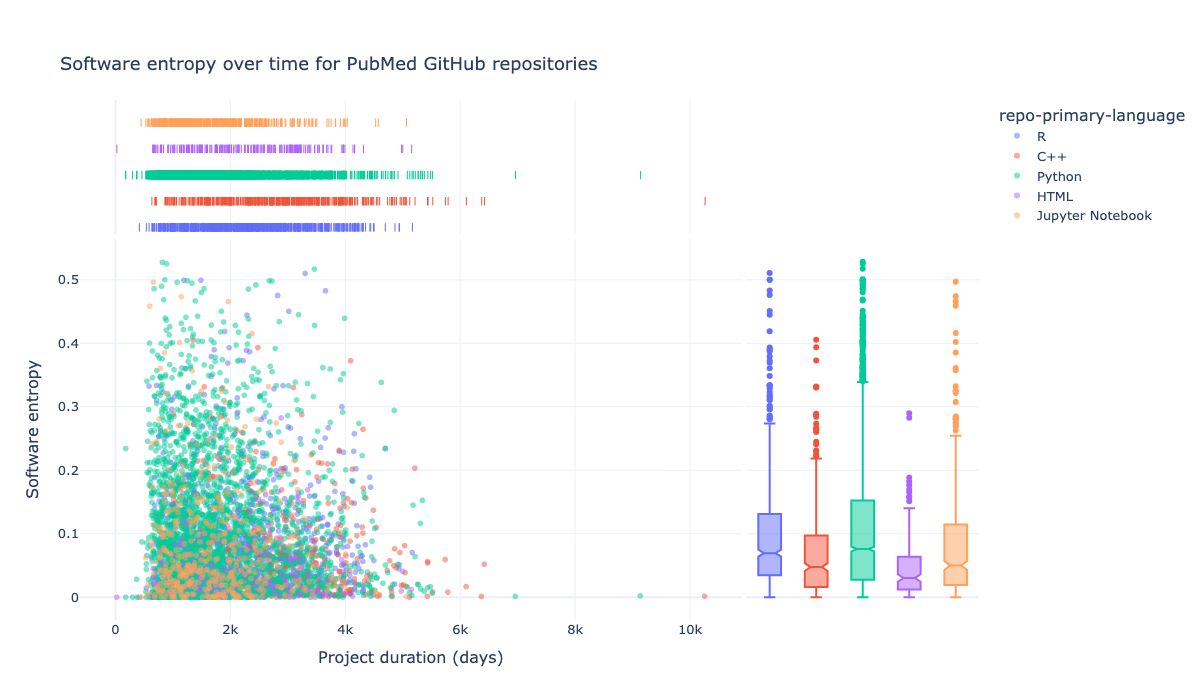

In [7]:
language_grouped_data = (
    df.groupby(["repo-primary-language"]).size().reset_index(name="Count")
)

fig = px.scatter(
    df[
        df["repo-primary-language"].isin(
            language_grouped_data.sort_values(by="Count")[-5:]["repo-primary-language"]
        )
    ],
    x="repo-days-of-existence",
    y="repo-agg-info-entropy",
    hover_data=["Repository URL"],
    width=1200,
    height=700,
    title="Software entropy over time for PubMed GitHub repositories",
    marginal_x="rug",
    marginal_y="box",
    opacity=0.5,
    color="repo-primary-language",
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="Project duration (days)",
    yaxis_title="Software entropy",
)
fig.write_image(image_file := "images/software-information-entropy-top-5-langs.png")
display(Image(filename=image_file))

## What is the relationship between GitHub Stars and Forks for repositories?

We next explore how GitHub Stars and Forks are related within the repositories.

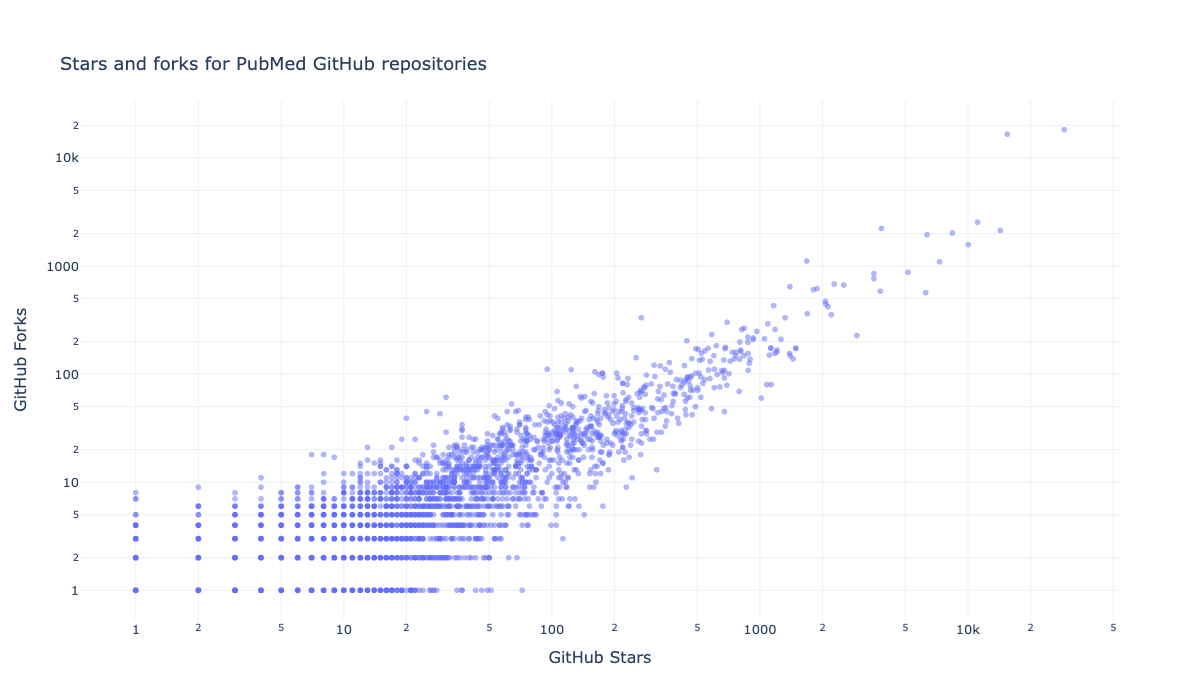

In [8]:
fig = px.scatter(
    df,
    x="repo-stargazers-count",
    y="repo-forks-count",
    hover_data=["Repository URL"],
    width=1200,
    height=700,
    title="Stars and forks for PubMed GitHub repositories",
    opacity=0.5,
    log_y=True,
    log_x=True,
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="GitHub Stars",
    yaxis_title="GitHub Forks",
)
fig.write_image(image_file := "images/pubmed-stars-and-forks.png")
display(Image(filename=image_file))

## How do GitHub Stars, software entropy, and time relate?

The next section explores how GitHub Stars, software entropy, and time relate to one another.

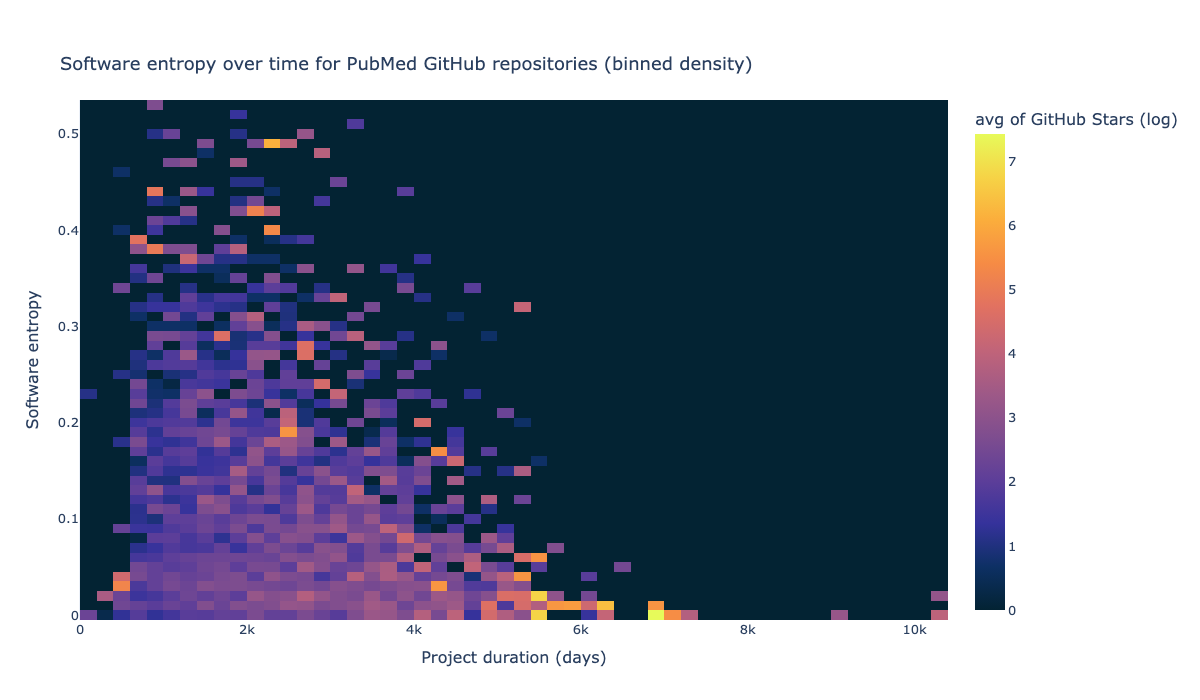

In [9]:
df["GitHub Stars (log)"] = np.log(
    df["repo-stargazers-count"].apply(lambda x: x if x > 0 else None)  # avoid log(0)
)

df_plot = df.dropna(subset=["GitHub Stars (log)"])

fig = px.density_heatmap(
    df_plot,
    x="repo-days-of-existence",
    y="repo-agg-info-entropy",
    z="GitHub Stars (log)",  # aggregate value per bin
    histfunc="avg",  # mean log stars per bin (could use "sum" or "count")
    nbinsx=60,
    nbinsy=60,
    color_continuous_scale=px.colors.sequential.thermal,
    hover_data=["Repository URL"],
    width=1200,
    height=700,
    title="Software entropy over time for PubMed GitHub repositories (binned density)",
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="Project duration (days)",
    yaxis_title="Software entropy",
)
fig.write_image(image_file := "images/software-information-entropy-gh-stars.png")
display(Image(filename=image_file))

## How do GitHub Forks, software entropy, and time relate?

The next section explores how GitHub Forks, software entropy, and time relate to one another.

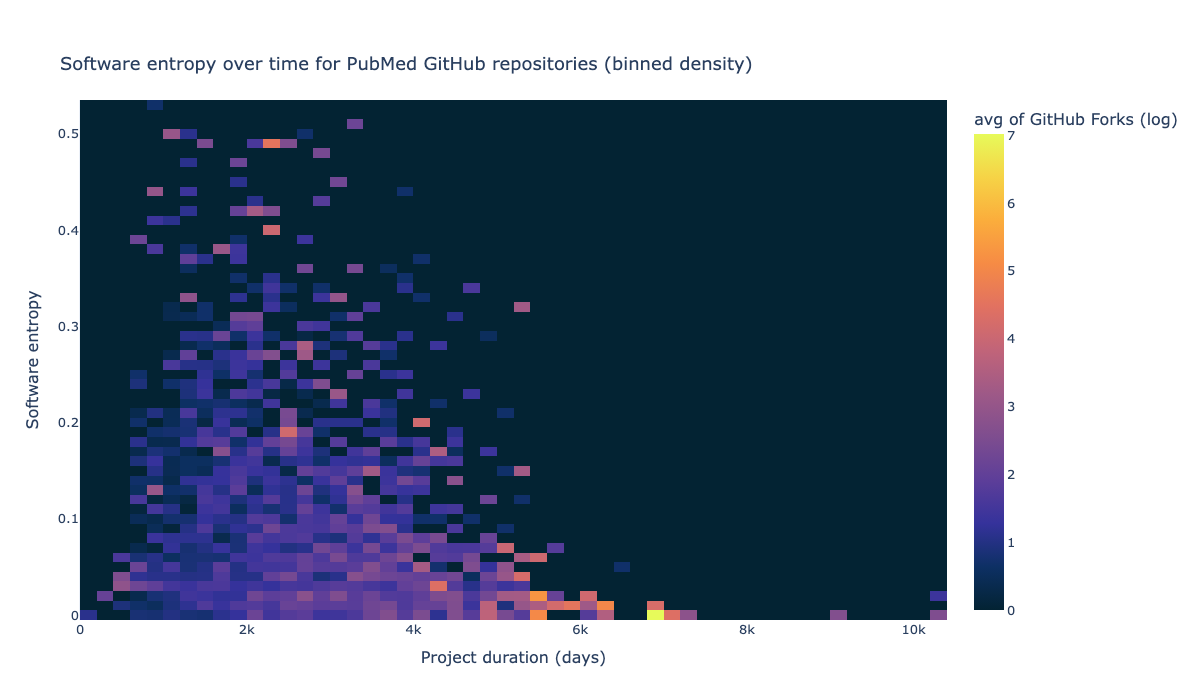

In [10]:
df["GitHub Forks (log)"] = np.log(
    df["repo-forks-count"].apply(
        # move 0's to None to avoid log(0)
        lambda x: x if x > 0 else None
    )
)

# Drop rows with missing values in the relevant columns
df_plot = df.dropna(
    subset=["GitHub Forks (log)", "repo-days-of-existence", "repo-agg-info-entropy"]
)

fig = px.density_heatmap(
    df_plot,
    x="repo-days-of-existence",
    y="repo-agg-info-entropy",
    z="GitHub Forks (log)",  # value to aggregate per bin
    histfunc="avg",  # mean log forks per bin (can use "sum" or "count")
    nbinsx=60,
    nbinsy=60,
    color_continuous_scale=px.colors.sequential.thermal,
    width=1200,
    height=700,
    title="Software entropy over time for PubMed GitHub repositories (binned density)",
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="Project duration (days)",
    yaxis_title="Software entropy",
)
fig.write_image(image_file := "images/software-information-entropy-forks.png")
display(Image(filename=image_file))

## What is the relationship between GitHub Stars and Open Issues for the repositories?

Below we explore how GitHub Stars and Open Issues are related for the repositories.

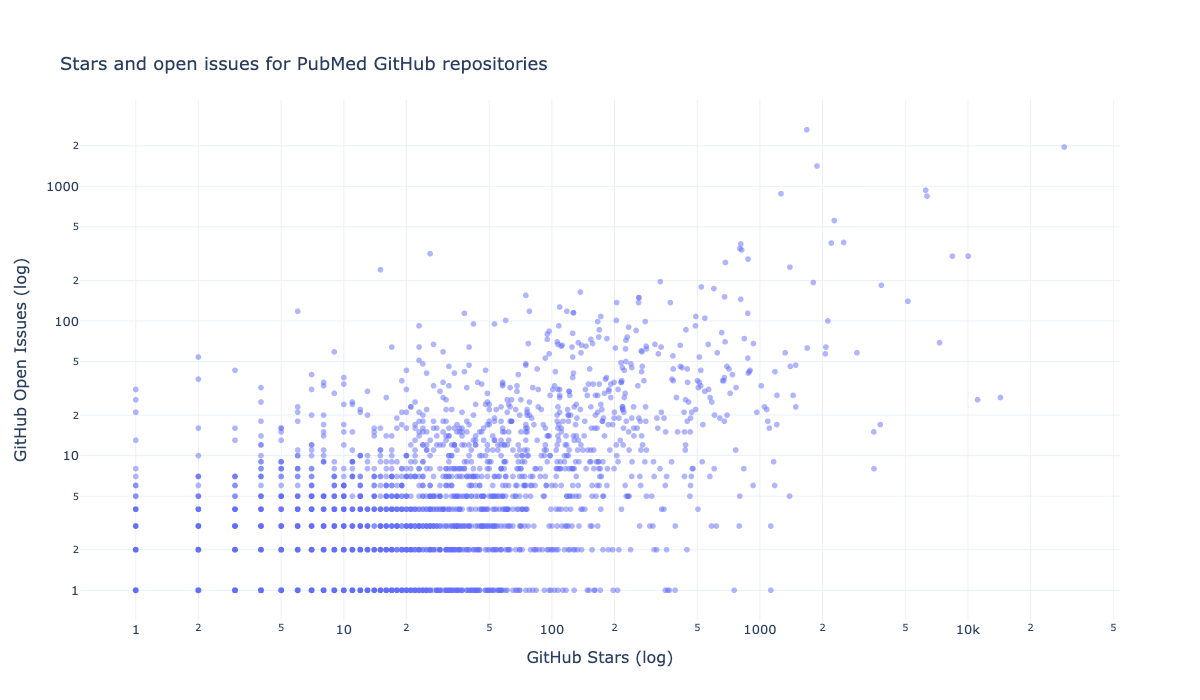

In [11]:
df["GitHub Open Issues (log)"] = np.log(
    df["repo-issues-open-count"].apply(
        # move 0's to None to avoid divide by 0
        lambda x: x if x > 0 else None
    )
)

fig = px.scatter(
    df,
    x="repo-stargazers-count",
    y="repo-issues-open-count",
    hover_data=["Repository URL"],
    width=1200,
    height=700,
    title="Stars and open issues for PubMed GitHub repositories",
    opacity=0.5,
    log_y=True,
    log_x=True,
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="GitHub Stars (log)",
    yaxis_title="GitHub Open Issues (log)",
)
fig.write_image(image_file := "images/pubmed-stars-and-open-issues.png")
display(Image(filename=image_file))

## How do software entropy, time, and GitHub issues relate to one another?

The next section visualizes how software entropy, time, and GitHub issues relate to one another.

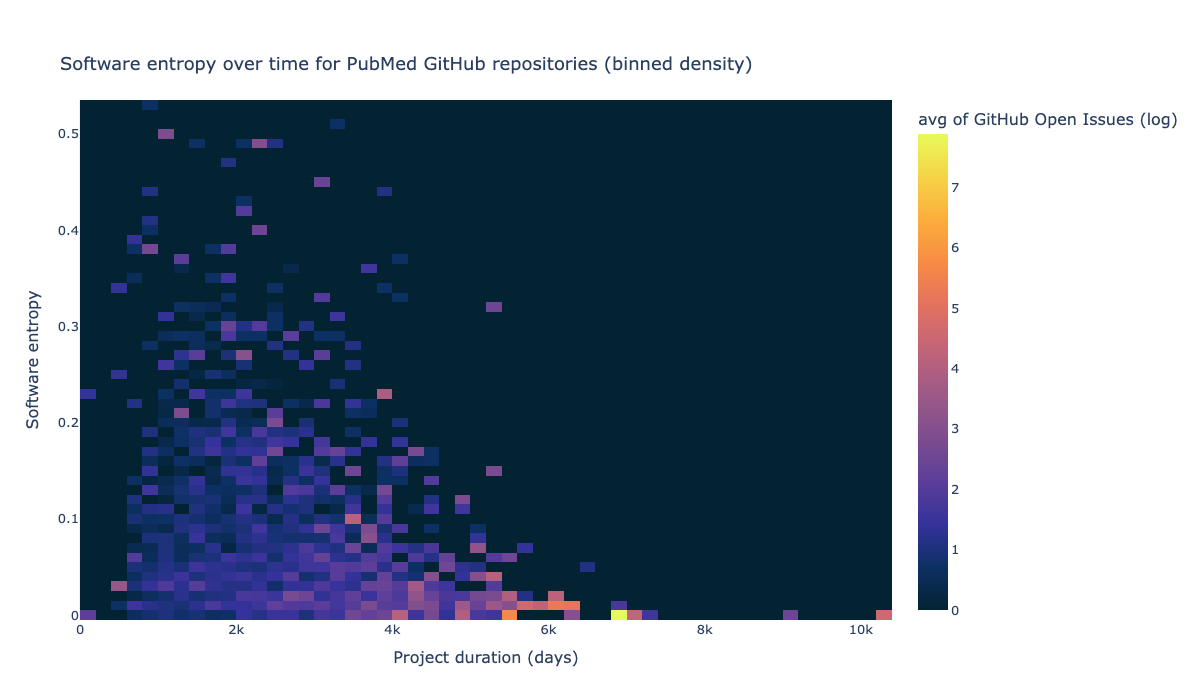

In [12]:
df["GitHub Open Issues (log)"] = np.log(
    df["repo-issues-open-count"].apply(
        # move 0's to None to avoid log(0)
        lambda x: x if x > 0 else None
    )
)

# Drop rows with missing values in the relevant columns
df_plot = df.dropna(
    subset=[
        "GitHub Open Issues (log)",
        "repo-days-of-existence",
        "repo-agg-info-entropy",
    ]
)

fig = px.density_heatmap(
    df_plot,
    x="repo-days-of-existence",
    y="repo-agg-info-entropy",
    z="GitHub Open Issues (log)",  # value to aggregate per bin
    histfunc="avg",  # mean log open issues per bin
    nbinsx=60,
    nbinsy=60,
    color_continuous_scale=px.colors.sequential.thermal,
    width=1200,
    height=700,
    title="Software entropy over time for PubMed GitHub repositories (binned density)",
)

fig.update_layout(
    font=dict(size=13),
    title={"yref": "container", "y": 0.9, "yanchor": "bottom"},
    xaxis_title="Project duration (days)",
    yaxis_title="Software entropy",
)

fig.write_image(image_file := "images/software-information-entropy-open-issues.png")
display(Image(filename=image_file))

```{bibliography}
---
style: unsrt
filter: docname in docnames
labelprefix: SB
---
```